# Projeto de Newsletter Diária de Cotação de Moedas 📨📈

## CONFIGURAÇÃO DE AMBIENTE ⚙️

In [1]:
# Bibliotecas necessárias
import os
import yaml
import json
import logging
import requests
import smtplib
import pandas as pd
import google.generativeai as genai
import matplotlib.pyplot as plt
from datetime import datetime
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

In [2]:
# Lista com os nomes dos diretórios a serem criados
directories = ["01_bronze", "02_silver", "03_gold", "04_graphs", "05_ia_responses"]

# Criar diretórios
for directory in directories:
    try:
        # Tenta criar o diretório. Se ele já existir, o erro FileExistsError é gerado.
        os.mkdir(directory)
        print(f"Diretório '{directory}' criado com sucesso.")
    except FileExistsError:
        # Se o diretório já existir, uma mensagem é impressa.
        print(f"O diretório '{directory}' já existe.")
    except Exception as e:
        # Para qualquer outro tipo de erro, uma mensagem genérica é exibida.
        print(f"Ocorreu um erro ao criar o diretório '{directory}': {e}")

O diretório '01_bronze' já existe.
O diretório '02_silver' já existe.
O diretório '03_gold' já existe.
O diretório '04_graphs' já existe.
O diretório '05_ia_responses' já existe.


##CONFIGURAÇÃO DE LOG


In [3]:
# Cria um objeto logger com o nome 'newsletter_logger'
newsletter_logger = logging.getLogger('newsletter_logger')

# Define o nível de registro como DEBUG. Isso significa que todas as mensagens com nível DEBUG e acima serão registradas
newsletter_logger.setLevel(logging.DEBUG)

# Criae manipuladores que imprimem mensagens de log no console (saída padrão) e escrevem mensagens de log em um arquivo chamado 'newsletter_logger.log'
console_handler = logging.StreamHandler()
file_handler = logging.FileHandler('newsletter_logger.log')

# Define um formatador que especifica o formato das mensagens de log
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Define o formatador para o manipulador do console e para o manipulador de arquivos
console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)

# Adiciona o manipulador do console ao logger. Isso significa que mensagens de log serão exibidas no console
#newsletter_logger.addHandler(console_handler)

# Adiciona o manipulador de arquivos ao logger. Isso significa que mensagens de log serão escritas no arquivo 'newsletter_logger.log'
newsletter_logger.addHandler(file_handler)

# Gera Log
newsletter_logger.info("Configurações de Log")

INFO:newsletter_logger:Configurações de Log


## CONFIGURAÇÕES DE FUNÇÕES

In [4]:
# Gera Log
newsletter_logger.info("Configurações de Funções")

def obter_taxas_de_cambio(api_key):
    """
    Função para obter as taxas de câmbio da API ExchangeRate-API.com.

    Args:
        api_key (str): Sua chave de API da ExchangeRate-API.com.

    Returns:
        dict: Um dicionário com as taxas de câmbio ou None em caso de erro.
    """
    url = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/BRL"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Lança uma exceção para respostas com erro (status code 4xx ou 5xx)

        dados = response.json()

        if dados.get("result") == "success":
            return dados.get("conversion_rates")
        else:
            newsletter_logger.info(f"Erro na resposta da API: {dados.get('error-type')}")
            return None

    except requests.exceptions.RequestException as e:
        newsletter_logger.info(f"Erro ao fazer a requisição: {e}")
        return None

def enviar_email_com_anexo(remetente, senha, destinatario, assunto, corpo, caminho_anexo):
    """
    Envia um e-mail com um anexo.

    Args:
        remetente (str): Endereço de e-mail do remetente.
        senha (str): Senha do aplicativo/gerada do e-mail do remetente.
        destinatario (str): Endereço de e-mail do destinatário.
        assunto (str): Assunto do e-mail.
        corpo (str): Corpo do texto do e-mail.
        caminho_anexo (str): Caminho completo para o arquivo a ser anexado.
    """
    # Configurações do e-mail
    msg = MIMEMultipart()
    msg['From'] = remetente
    msg['To'] = destinatario
    msg['Subject'] = assunto

    # Anexa o corpo do e-mail
    msg.attach(MIMEText(corpo, 'plain'))

    # Anexa o arquivo
    try:
        with open(caminho_anexo, "rb") as anexo:
            parte = MIMEBase("application", "octet-stream")
            parte.set_payload(anexo.read())

        encoders.encode_base64(parte)

        # Define o nome do arquivo no cabeçalho
        nome_arquivo = os.path.basename(caminho_anexo)
        parte.add_header("Content-Disposition", f"attachment; filename={nome_arquivo}")

        msg.attach(parte)

    except FileNotFoundError:
        newsletter_logger.info(f"Erro: O arquivo {caminho_anexo} não foi encontrado.")
        return
    except Exception as e:
        newsletter_logger.info(f"Ocorreu um erro ao anexar o arquivo: {e}")
        return

    # Conecta ao servidor e envia o e-mail
    try:
        servidor_smtp = "smtp.gmail.com"  # Exemplo para Gmail
        porta_smtp = 587

        with smtplib.SMTP(servidor_smtp, porta_smtp) as servidor:
            servidor.starttls()  # Inicia a segurança TLS
            servidor.login(remetente, senha)
            servidor.send_message(msg)
            newsletter_logger.info("E-mail enviado com sucesso!")

    except smtplib.SMTPAuthenticationError:
        newsletter_logger.info("Erro de autenticação. Verifique seu e-mail e senha do aplicativo.")
    except Exception as e:
        newsletter_logger.info(f"Ocorreu um erro ao enviar o e-mail: {e}")

INFO:newsletter_logger:Configurações de Funções


## DEFINE VARIAVEIS

In [5]:
# Gera Log
newsletter_logger.info("Definição de variaveis")

# Define Data atual
data_atual = datetime.now()

# Define Data atual no formato '%Y-%m-%d'
data_atual_str = data_atual.strftime('%Y-%m-%d')

# Define diretório e arquivo - Camada BRONZE
bronze_dir = os.path.join("01_bronze/", f"exchange_rates_bronze_{data_atual_str}.json")

# Define diretório e arquivo - Camada SILVER
silver_dir = os.path.join("02_silver/", f"exchange_rates_normalized_{data_atual_str}.json")

# Define diretório e arquivo - Camada GOLD
gold_dir = os.path.join("03_gold/", f"exchange_rates_{data_atual_str}.parquet")

# Define diretório e arquivo - Gráficos
graph_dir = os.path.join("04_graphs/", f"grafico_taxas_de_cambio_{data_atual_str}.pdf")

# Define diretório e arquivo - Saída IA
ia_output_dir = os.path.join("05_ia_responses/", f"ia_output.json")

# O nome do arquivo YAML
yaml_file = "config.yaml"

# Variaveis arquivo YAML
try:
  with open(yaml_file, "r") as arquivo_yaml:
    # Carrega o conteúdo do arquivo YAML em um dicionário Python
    configuracoes = yaml.safe_load(arquivo_yaml)

  # ExchangeRate API Key
  exchangerate_key = configuracoes['api_keys']['exchangerate_api_key']

  # Gemini API Key
  gemini_key = configuracoes['api_keys']['gemini_api_key']

  # Gemini API model
  gemini_model = configuracoes['ia_model']['gemini_model']

  # Define email e senha para envio do relatório
  meu_email = configuracoes['email']['meu_email']
  minha_senha_app = configuracoes['email']['minha_senha_app']

  # Define email do assinante
  email_destinatario = configuracoes['email']['email_destinatario']

except FileNotFoundError:
  newsletter_logger.info(f"Erro: O arquivo '{yaml_file}' não foi encontrado. Verifique o caminho e o nome do arquivo.")
except KeyError as e:
  newsletter_logger.info(f"Erro: Chave não encontrada no arquivo YAML. Verifique a estrutura. Chave faltando: {e}")
except Exception as e:
  newsletter_logger.info(f"Ocorreu um erro ao carregar o arquivo YAML: {e}")

INFO:newsletter_logger:Definição de variaveis


## 1° PASSO: COLETA DE DADOS DA API E ARMAZENAMENTO BRUTO (CAMADA BRONZE) 🥉

In [6]:
# Gera Log
newsletter_logger.info("1° PASSO: COLETA DE DADOS DA API E ARMAZENAMENTO BRUTO (CAMADA BRONZE)")

# Executa função para retornar taxas
taxas = obter_taxas_de_cambio(exchangerate_key)

# json.dump escreve o dicionário Python em um arquivo no formato JSON
# indent=4 formata o JSON para ser mais legível
# ensure_ascii=False garante que caracteres especiais (como R$) sejam salvos corretamente
with open(bronze_dir, 'w', encoding='utf-8') as json_file:
    json.dump(taxas, json_file, indent=4, ensure_ascii=False)

# Gera Log
newsletter_logger.info(f"Taxas de câmbio salvas com sucesso em: {bronze_dir}")

INFO:newsletter_logger:1° PASSO: COLETA DE DADOS DA API E ARMAZENAMENTO BRUTO (CAMADA BRONZE)
INFO:newsletter_logger:Taxas de câmbio salvas com sucesso em: 01_bronze/exchange_rates_bronze_2025-09-03.json


## 2° PASSO: CAPTURAR DADOS DA CAMADA BRONZE🥉, NORMALIZAR E GRAVAR NA CAMADA SILVER🥈

In [7]:
# Gera Log
newsletter_logger.info("2° PASSO: CAPTURAR DADOS DA CAMADA BRONZE, NORMALIZAR E GRAVAR NA CAMADA SILVER")

# Le o arquivo JSON
with open(bronze_dir, 'r', encoding='utf-8') as json_file:
    taxas_dict = json.load(json_file)

# Converte o dictionary para uma lista de tuplas e então para DataFrame
df_silver = pd.DataFrame(list(taxas_dict.items()), columns=['Moeda', 'Taxa'])

# Garante a qualidade dos dados (remover taxas nulas ou negativas)
df_silver_qa = df_silver[df_silver['Taxa'] > 0].copy()

# Normalizr os dados adicionando as novas colunas
moeda_base = 'BRL' # Define moeda base como BRL
df_silver_qa['Moeda_Base'] = moeda_base
df_silver_qa['Timestamp'] = pd.Timestamp.now()

# Reordenr colunas para melhor organização
df_silver_qa = df_silver_qa[['Moeda', 'Taxa', 'Moeda_Base', 'Timestamp']]

# Salva em formato JSON
df_silver_qa.to_json(silver_dir)

# Gera Log
newsletter_logger.info(f"DataFrame da camada Bronze processado com sucesso e salvo na camada Silver em: {silver_dir}")

INFO:newsletter_logger:2° PASSO: CAPTURAR DADOS DA CAMADA BRONZE, NORMALIZAR E GRAVAR NA CAMADA SILVER
INFO:newsletter_logger:DataFrame da camada Bronze processado com sucesso e salvo na camada Silver em: 02_silver/exchange_rates_normalized_2025-09-03.json


##3° PASSO: CAPTURAR DADOS DA CAMADA SILVER🥈 E GRAVAR EM PARQUET NA CAMADA GOLD🥇

In [8]:
# Gera Log
newsletter_logger.info("3° PASSO: CAPTURAR DADOS DA CAMADA SILVER E GRAVAR EM PARQUET NA CAMADA GOLD")

# Le o arquivo JSON
with open(silver_dir, 'r', encoding='utf-8') as json_file:
    taxas_dict = json.load(json_file)
df_gold = pd.read_json(silver_dir)

# Filtra apenas USD e JPY
df_gold = df_gold[df_gold['Moeda'].isin(['USD', 'JPY'])]

# Salva em formato Parquet sem o índice do DataFrame
df_gold.to_parquet(gold_dir, index=False)

newsletter_logger.info(f"DataFrame da camada Silver processado com sucesso e salvo na camada Gold em: {gold_dir}")

INFO:newsletter_logger:3° PASSO: CAPTURAR DADOS DA CAMADA SILVER E GRAVAR EM PARQUET NA CAMADA GOLD
INFO:newsletter_logger:DataFrame da camada Silver processado com sucesso e salvo na camada Gold em: 03_gold/exchange_rates_2025-09-03.parquet


In [9]:
df_gold

,Moeda,Taxa,Moeda_Base,Timestamp
70,JPY,27.1569,BRL,2025-09-03 14:27:15
146,USD,0.1829,BRL,2025-09-03 14:27:15


## 4° PASSO: GERA GRÁFICO COM AS PRINCIPAIS MOEDAS 📈🪙💱

INFO:newsletter_logger:4° PASSO: GERA GRÁFICO COM AS PRINCIPAIS MOEDAS
INFO:newsletter_logger:Gráfico salvo com sucesso no arquivo: '04_graphs/grafico_taxas_de_cambio_2025-09-03.pdf'


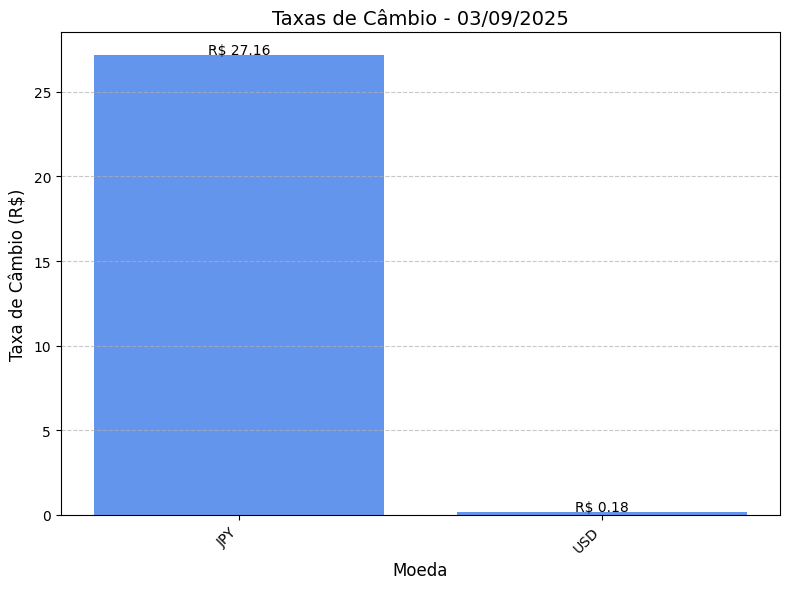

In [10]:
# Gera Log
newsletter_logger.info("4° PASSO: GERA GRÁFICO COM AS PRINCIPAIS MOEDAS" )

# Le o arquivo PARQUET
df_graph = pd.read_parquet(gold_dir)

# --- Início das configurações de gráfico ---
plt.figure(figsize=(8, 6)) # Opcional: ajusta o tamanho da figura para melhor visualização
plt.bar(df_graph['Moeda'], df_graph['Taxa'], color='cornflowerblue')

# Adição para incluir os valores nas barras
# Loop para percorrer cada barra do gráfico
for index, value in enumerate(df_graph['Taxa']):
    # plt.text(x, y, texto, alinhamento_horizontal)
    # x = index (posição da barra: 0, 1, 2...)
    # y = value + offset (altura da barra + um pequeno espaço para não ficar colado)
    # texto = f'{value:.2f}' (o valor formatado com 2 casas decimais)
    plt.text(index, value + 0.05, f'R$ {value:.2f}', ha='center', fontsize=10)
# --- Fim das configurações de gráfico ---

# Adiciona títulos e rótulos
plt.xlabel('Moeda', fontsize=12)
plt.ylabel('Taxa de Câmbio (R$)', fontsize=12)
plt.title(f'Taxas de Câmbio - {data_atual.strftime("%d/%m/%Y")}', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotaciona os rótulos do eixo x para evitar sobreposição
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adiciona uma grade horizontal
plt.tight_layout() # Ajusta o layout para garantir que tudo se encaixe bem

# Salva o gráfico no arquivo PDF
plt.savefig(graph_dir, format='pdf')

newsletter_logger.info(f"Gráfico salvo com sucesso no arquivo: '{graph_dir}'")

## 5° PASSO: GERAR CONTEÚDO DO EMAIL COM IA-GEMINI🤖 E GRAVAR EM JSON 🗃️

In [23]:
# Gera Log
newsletter_logger.info("5° PASSO: GERAR CONTEÚDO DO EMAIL COM IA (GEMINI)")

# Utiliza credenciais do Gemini
genai.configure(api_key=gemini_key)

# Inicializa modelo do Gemini
model = genai.GenerativeModel(f'{gemini_model}')

# Define o prompt
prompt = f"""
Você é um agente especialista no mercado financeiro, responsável por ler dados sobre o valor do USD e JPY frente ao BRL.
Use os dados fornecidos sobre a cotação da moeda e gere um texto de Newsletter informando noticias relevantes no dia de hoje, que tenhan relação com USD e JPY.

Acrecente ao final links de notícias relevantes do dia, sobre o tema. Os links devem estar funcionado para que o assinante acesse.
Acrescente ao final a frase: 'Atenciosamente, Seu Consultor Financeiro.'.

### Exemplo de Saida esperada: 'Olá, Assinante. Hoje a cotação do USD ficou em 0,18 e do JPY em 27,18. O USD sofreu o impacto do FED que divulgou bons numeros no mercado de trabalho, já o JPY se manteve estavel mesmo com a melhora no aumento do PIB Japones. Links de notícias relevantes: infomoney.com/noticia123.'
### Dados: {df_gold}
"""

# Configuração do Gemini
generation_config = {
    "max_output_tokens": 1000,  # Limita a resposta 1000 tokens
    "temperature": 0.5       # Torna a resposta mais focada
}

# Envia o prompt
response = model.generate_content(
  prompt
  #,generation_config=generation_config
)

# Imprime a resposta
df_ia = response.text

# Captura a quantidade de tokens do prompt
token_count = model.count_tokens(prompt)

# Gera Log
newsletter_logger.info(f"Conteúdo gerado com sucesso com {token_count}")

INFO:newsletter_logger:5° PASSO: GERAR CONTEÚDO DO EMAIL COM IA (GEMINI)
INFO:newsletter_logger:Conteúdo gerado com sucesso com total_tokens: 305



In [28]:
# Cria variaveis com resposta da IA, para armazenamento
ia_resp_output = { datetime.now().strftime('%Y-%m-%d %H:%M') : df_ia }
ia_resp_output_new = []

# Verifica se o arquivo JSON já existe e não está vazio
if os.path.exists(ia_output_dir) and os.path.getsize(ia_output_dir) > 0:
    with open(ia_output_dir, 'r', encoding='utf-8') as f:
      ia_resp_output_new = json.load(f)

# Garante que os dados existentes sejam uma lista para poder adicionar.
if not isinstance(ia_resp_output_new, list):
    ia_resp_output_new = [ia_resp_output_new]

# Adicionar os novos dados à lista.
ia_resp_output_new.append(ia_resp_output)

# Escreve a lista completa de volta no arquivo
with open(ia_output_dir, 'w', encoding='utf-8') as f:
    json.dump(ia_resp_output_new, f, ensure_ascii=False, indent=4)

# Gera Log
newsletter_logger.info(f"Conteúdo gravado com sucesso no arquivo: '{ia_output_dir}'")

INFO:newsletter_logger:Conteúdo gravado com sucesso no arquivo: '05_ia_responses/ia_output.json'


## 6° PASSO: ENVIAR E-MAIL COM RELATÓRIO 📨

In [ ]:
# Gera Log
newsletter_logger.info("6° PASSO: ENVIAR E-MAIL COM RELATÓRIO")

# Envia o e-mail
assunto_email = "Relatório Diário - Cotação das principais moedas"
corpo_email = f"{df_ia}"

enviar_email_com_anexo(
    remetente=meu_email,
    senha=minha_senha_app,
    destinatario=email_destinatario,
    assunto=assunto_email,
    corpo=corpo_email,
    caminho_anexo=graph_dir
)

2025-09-03 01:20:23,969 - newsletter_logger - INFO - 6° PASSO: ENVIAR E-MAIL COM RELATÓRIO
INFO:newsletter_logger:6° PASSO: ENVIAR E-MAIL COM RELATÓRIO
2025-09-03 01:20:25,845 - newsletter_logger - INFO - E-mail enviado com sucesso!
INFO:newsletter_logger:E-mail enviado com sucesso!


# ‼️Validar LOG

In [ ]:
with open("newsletter_logger.log", "r") as f:
  conteudo = f.read()

print(conteudo)

2025-09-03 01:14:15,306 - newsletter_logger - INFO - Configurações de Log
2025-09-03 01:14:17,372 - newsletter_logger - INFO - Configurações de Funções
2025-09-03 01:14:18,814 - newsletter_logger - INFO - Definição de variaveis
2025-09-03 01:14:20,439 - newsletter_logger - INFO - 1° PASSO: COLETA DE DADOS DA API E ARMAZENAMENTO BRUTO (CAMADA BRONZE)
2025-09-03 01:15:21,086 - newsletter_logger - INFO - Definição de variaveis
2025-09-03 01:15:22,867 - newsletter_logger - INFO - 1° PASSO: COLETA DE DADOS DA API E ARMAZENAMENTO BRUTO (CAMADA BRONZE)
2025-09-03 01:15:22,944 - newsletter_logger - INFO - Taxas de câmbio salvas com sucesso em: 01_bronze/exchange_rates_bronze_2025-09-03.json
2025-09-03 01:15:24,533 - newsletter_logger - INFO - 2° PASSO: CAPTURAR DADOS DA CAMADA BRONZE, NORMALIZAR E GRAVAR NA CAMADA SILVER
2025-09-03 01:15:24,558 - newsletter_logger - INFO - DataFrame da camada Bronze processado com sucesso e salvo na camada Silver em: 02_silver/exchange_rates_normalized_2025-09

#‼️Validar Output's IA

In [ ]:
with open(ia_output_dir, "r") as f:
  conteudo = f.read()

print(conteudo)

[
    {
        "2025-09-03 01:27": "Olá, Assinante.\n\nHoje, 03 de setembro de 2025, a cotação do Dólar Americano (USD) frente ao Real (BRL) ficou em **0,18**, enquanto o Iene Japonês (JPY) se manteve em **27,18**.\n\nO Dólar Americano (USD) demonstrou resiliência no dia de hoje, impulsionado por dados robustos de inflação dos EUA, que reforçam a expectativa de que o Federal Reserve (FED) manterá uma postura mais conservadora em relação a cortes de juros. Esse cenário tende a fortalecer a moeda, apesar das pressões globais. Já o Iene Japonês (JPY), mesmo com a divulgação de um crescimento ligeiramente acima do esperado no PIB japonês no último trimestre, não conseguiu demonstrar ganhos significativos. A manutenção da política monetária ultra-expansionista do Banco do Japão (BoJ) continua a ser o principal fator limitante para uma valorização mais expressiva da moeda frente aos seus pares e ao BRL.\n\nLinks de notícias relevantes:\n*   [Dólar sobe com dados de inflação dos EUA e reforç